In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/airline-passengers.csv',index_col='Month',parse_dates=True)


In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


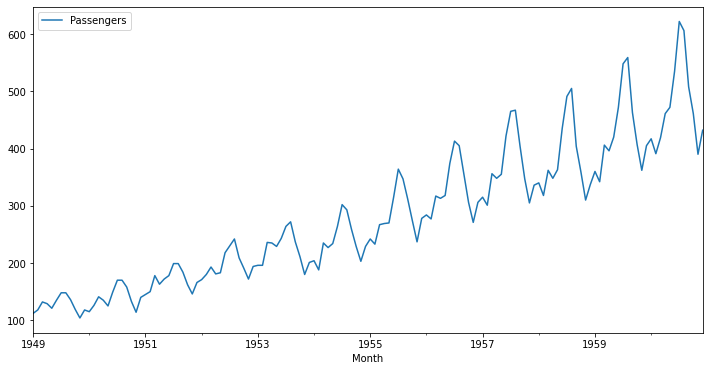

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


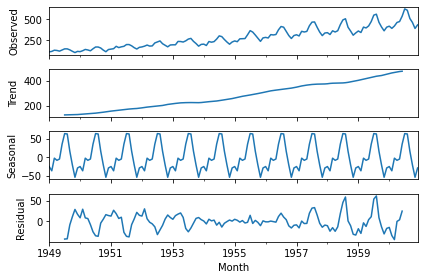

In [6]:
results = seasonal_decompose(df['Passengers'])
results.plot();

In [7]:
len(df)

144

In [8]:
train = df.iloc[:120]
test = df.iloc[120:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df.head(),df.tail()

(            Passengers
 Month                 
 1949-01-01         112
 1949-02-01         118
 1949-03-01         132
 1949-04-01         129
 1949-05-01         121,             Passengers
 Month                 
 1960-08-01         606
 1960-09-01         508
 1960-10-01         461
 1960-11-01         390
 1960-12-01         432)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# We do the same thing, but now instead for 12 months
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [15]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fit model
model.fit(generator,epochs=100)

Epoch 1/100
108/108 [==============================] - 2s 6ms/step - loss: 0.0419
Epoch 2/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0136
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0116
Epoch 4/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0110
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0103
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0100
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0093
Epoch 8/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0060
Epoch 9/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0067
Epoch 10/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0123
Epoch 11/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 12/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 13/100


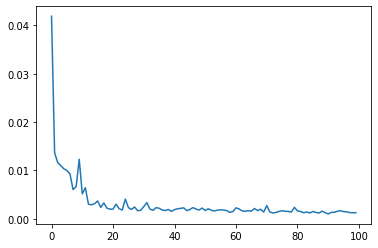

In [18]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [19]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [22]:
true_predictions = scaler.inverse_transform(test_predictions)

In [23]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
test.head()

,Passengers,Predictions
Month,,
1959-01-01,360,369.071928
1959-02-01,342,350.369345
1959-03-01,406,382.835490
1959-04-01,396,385.269806
1959-05-01,420,403.050032


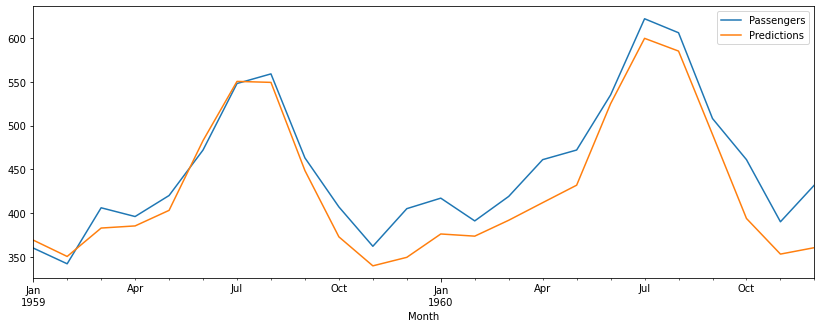

In [25]:
test.plot(figsize=(14,5))

In [26]:
test['APE'] = (test['Passengers'] - test['Predictions']) / test['Passengers'] * 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
test

,Passengers,Predictions,APE
Month,,,
1959-01-01,360,369.071928,-2.519980
1959-02-01,342,350.369345,-2.447177
1959-03-01,406,382.835490,5.705544
1959-04-01,396,385.269806,2.709645
1959-05-01,420,403.050032,4.035707
1959-06-01,472,482.765545,-2.280836
1959-07-01,548,550.412301,-0.440201
1959-08-01,559,549.299736,1.735289
1959-09-01,463,448.528158,3.125668


In [28]:
test['APE'].mean()

5.459055234096021

In [29]:
test.shape

(24, 3)